# Лабораторная работа №7 (Проведение исследований моделями семантической сегментации) 

# 1.	Выбор начальных условий

Для выполнения данной работы используется датасет сегментации футбольных игроков на поле.
https://www.kaggle.com/datasets/ihelon/football-player-segmentation/data

Данный датасет полезен при проведении футбольных матчей, что уменьшает трудозатраты в разрешении спорных ситуаций

Как метрику в моделях было принято решение использовать Intersection‑over‑Union (IoU) — это отношение площади пересечения предсказанной маски P и истинной маски G к площади их объединения. Т.к. эта метрика позволяет геометрически правильно оценить правильно выделенные пиксели

Загрузим датасет с kaggle

In [1]:
import kagglehub

path = kagglehub.dataset_download("ihelon/football-player-segmentation")

print("Path to dataset files:", path)

100%|██████████| 317M/317M [00:09<00:00, 34.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ihelon/football-player-segmentation/versions/1


Загрузим библиотеку **segmentation_models_pytorch** для работы с сегментационными моделями

In [2]:
%pip install imantics segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=160

Загрузим необходимые библиотеки для дальнейшей работы

In [ ]:
import os
import random
import json

from tqdm import tqdm
import imantics
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as A

Зададим констатны для размеры изображений

In [71]:
N_IMAGES = 512
TRAIN_IMAGE_SIZE = 512
INPUT_IMAGE_SIZE = (1920, 1080)

Загрузим аннотации для нашего датасета

In [72]:
with open(path + "/annotations/instances_default.json") as f:
    annotations = json.load(f)

Подготовим датасет для дальнейшей работы с torch

In [73]:
map_id_filename = {}
for index in range(len(annotations["images"])):
    map_id_filename[annotations["images"][index]["id"]] = annotations["images"][index]["file_name"]

In [74]:
images = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE, 3), dtype=np.uint8)

for image_id, image_filename in map_id_filename.items():
    cur_image = cv2.imread(path + f"/images/{image_filename}")
    cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
    cur_image = cv2.resize(cur_image, (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE))

    images[image_id - 1] = cur_image

In [79]:
masks = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE), dtype=bool)

for index in range(len(annotations["annotations"])):
    image_id = annotations["annotations"][index]["image_id"]
    segmentation = annotations["annotations"][index]["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*INPUT_IMAGE_SIZE).array
    cur_mask = cv2.resize(cur_mask.astype(float), (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)) >= 0.5

    masks[image_id - 1] = masks[image_id - 1] | cur_mask

Визуализируем подготовленные изображения и маски для них, чтобы проверить правильность загрузки датасета

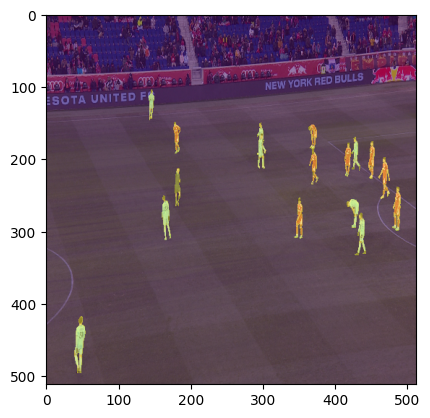

In [80]:
plt.imshow(images[0])
plt.imshow(masks[0], alpha=0.5)

С помощью класса CFG создадим конфиг, который будем использовать в дальнейшей работе

In [81]:
class CFG:
    seed = 42
    train_size = 0.8
    batch_size = 4
    lr = 0.001
    n_epochs = 5
    device = "cuda"

Используем заданный seed для рандомной генериции внутренних значений torch-а

In [82]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

Создадим индексы, которые будем использовать в даталоадере

In [83]:
indexes = list(range(N_IMAGES))
train_indexes = indexes[: int(N_IMAGES * CFG.train_size)]
valid_indexes = indexes[int(N_IMAGES * CFG.train_size) :]

Используем стандартый бейзлайн с небольшим изменением экспозиции

In [84]:
def get_transforms():
    return A.Compose(
        [
            A.HueSaturationValue( # Change colors
                p=1.0,
                hue_shift_limit=(-20, 20),
                sat_shift_limit=(-30, 30),
                val_shift_limit=(-20, 20),
            ),
            A.HorizontalFlip(p=0.5),
        ],
        p=1.0
    )

Напишем класс для загрузки кастомного датасета. Метод **__getitem__** используется при получении значений в dataloader-е

In [92]:
class CustomDataset(Dataset):
    def __init__(self, indexes, transform=None, preprocess=None):
        self.indexes = indexes
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        _index = self.indexes[index]

        image = images[_index]
        mask = masks[_index]

        if self.transform:
            data = {"image": image, "mask": mask.astype(np.uint8)}
            augmented = self.transform(**data)
            image, mask = augmented["image"], augmented["mask"]

        if self.preprocess:
            image = self.preprocess(image)

        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask.astype(bool), dtype=torch.float)

        image = image.permute(2, 0, 1)
        mask = mask.unsqueeze(0)

        return {"image": image, "mask": mask}

Загрузим веса модели Unet

In [93]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

Используем функцию для предподготовки датасета

In [94]:
preprocess_input = get_preprocessing_fn("resnet34", pretrained="imagenet")

Загрузим наши датасеты

In [95]:
train_dataset = CustomDataset(
    train_indexes, transform=get_transforms(), preprocess=preprocess_input
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_indexes, preprocess=preprocess_input)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)

Загрузим модель в нужное устройство. Добавим функцию расчёта ошибки и оптимизатор поставим Adam

In [96]:
model.to(CFG.device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=CFG.lr)

Напишем функцию для вычисления метрики IoU - Intersection over Union

In [97]:
def iou(outputs, labels) -> float:
    intersection = np.sum(np.logical_and(outputs, labels), axis=(1, 2, 3))
    union = np.sum(np.logical_or(outputs, labels), axis=(1, 2, 3))
    iou = intersection / union
    return np.mean(iou)

Напишем функцию для процесса обучения. Добавим списки для хранения истории, которые дальше будем использовать для визуализации процесса обучения

In [98]:
train_loss_history = []
val_loss_history = []
train_iou_history = []
val_iou_history = []

for epoch in range(CFG.n_epochs):
    train_loss = 0
    train_iou = 0
    model.train()
    for i, batch in tqdm(enumerate(train_dataloader)):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
        train_iou += _iou

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)

    val_loss = 0
    val_iou = 0
    model.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_dataloader)):
            inputs = batch["image"].to(CFG.device)
            labels = batch["mask"].to(CFG.device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
            val_iou += _iou

    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(
        "Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train IOU: {:.4f}, Val IOU: {:.4f}".format(
            epoch + 1, CFG.n_epochs, train_loss, val_loss, train_iou, val_iou
        )
    )

103it [00:31,  3.31it/s]
26it [00:02, 10.58it/s]


Epoch [1/5], Train Loss: 0.0795, Val Loss: 0.0184, Train IOU: 0.6782, Val IOU: 0.8122


103it [00:30,  3.39it/s]
26it [00:02, 10.80it/s]


Epoch [2/5], Train Loss: 0.0147, Val Loss: 0.0112, Train IOU: 0.8171, Val IOU: 0.8241


103it [00:30,  3.41it/s]
26it [00:02,  9.72it/s]


Epoch [3/5], Train Loss: 0.0100, Val Loss: 0.0080, Train IOU: 0.8462, Val IOU: 0.8627


103it [00:30,  3.39it/s]
26it [00:02, 10.73it/s]


Epoch [4/5], Train Loss: 0.0083, Val Loss: 0.0069, Train IOU: 0.8579, Val IOU: 0.8728


103it [00:30,  3.37it/s]
26it [00:02, 10.74it/s]

Epoch [5/5], Train Loss: 0.0106, Val Loss: 0.0087, Train IOU: 0.8221, Val IOU: 0.8275


Выведем результаты обучения и в виде графика

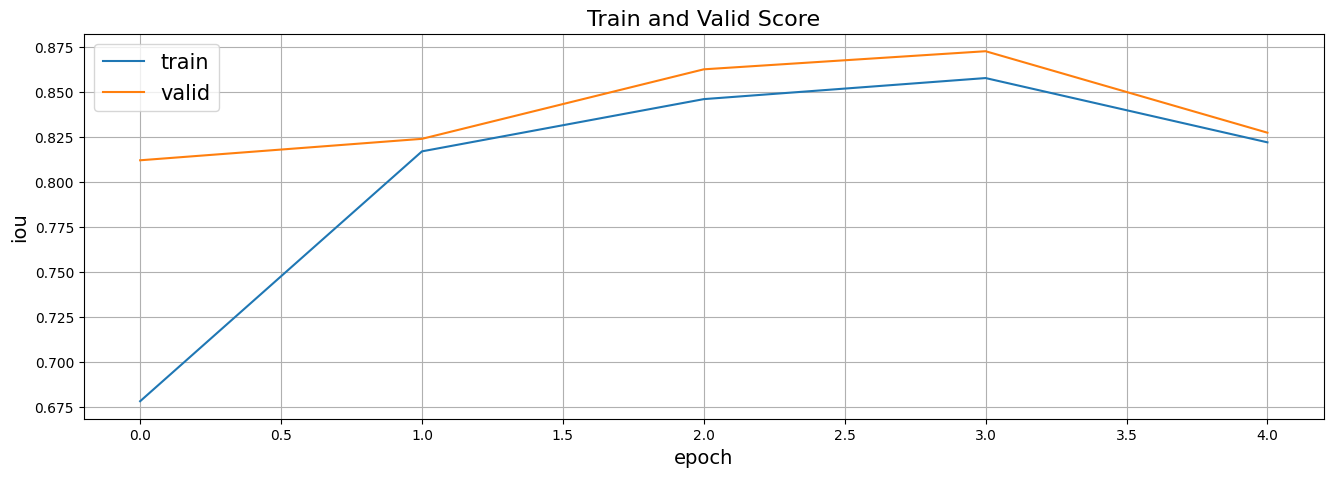

In [99]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_iou_history, label="train")
plt.plot(range(CFG.n_epochs), val_iou_history, label="valid")

plt.title("Train and Valid Score", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

Визуализируем пример работы модели. Выведем реальную и предсказанную маску

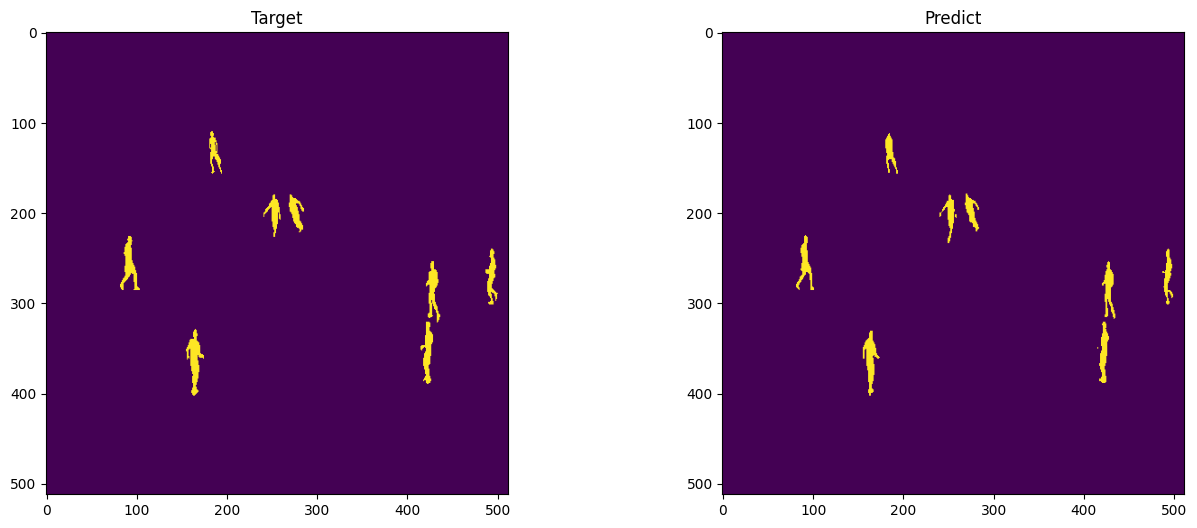

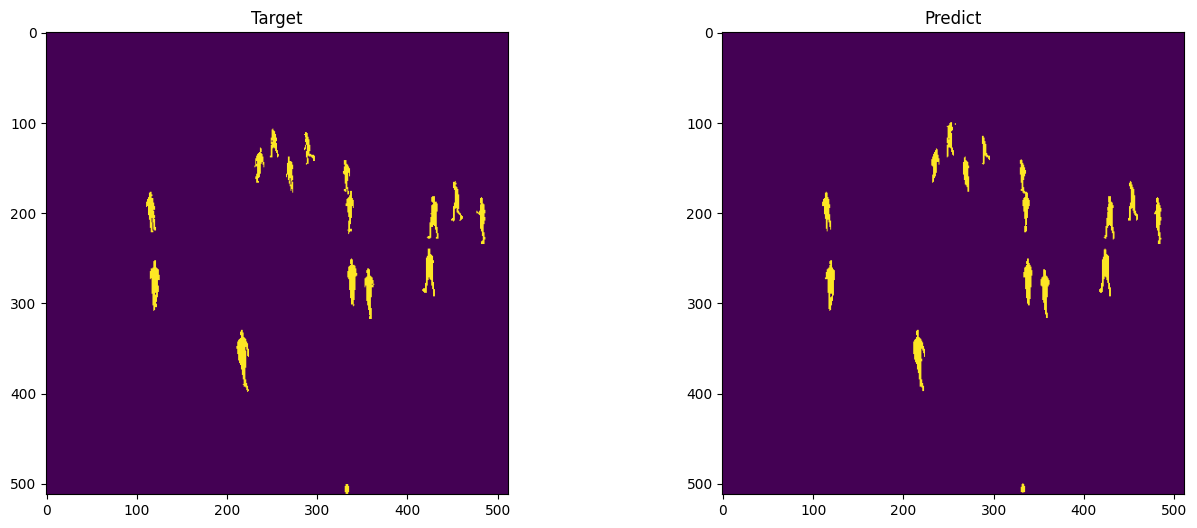

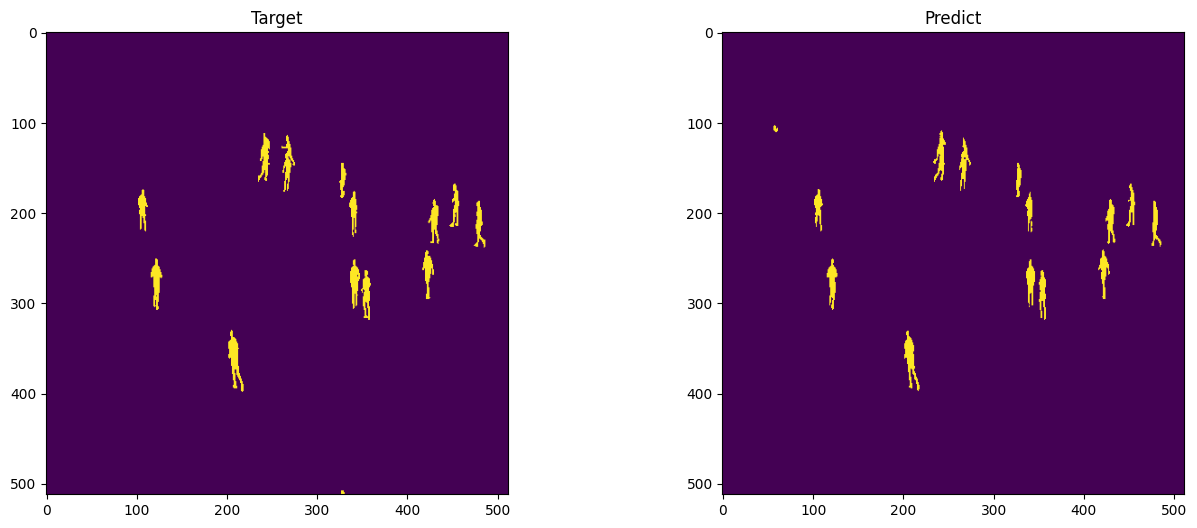

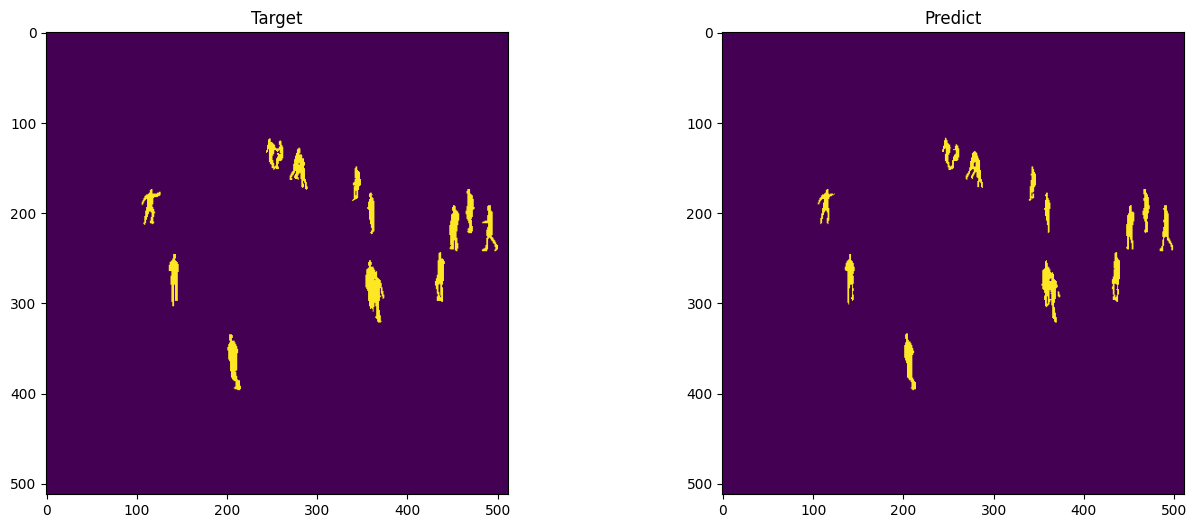

In [100]:
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        outputs = model(inputs)

        np_labels = labels.detach().cpu().numpy()
        np_outputs = outputs.detach().cpu().numpy()

        for i in range(len(np_labels)):
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(np_labels[i][0])
            plt.title("Target")
            plt.subplot(1, 2, 2)
            plt.imshow(np_outputs[i][0] >= 0)
            plt.title("Predict")
            plt.show()

        break

Проделаем аналогичные действия для модели SegFormer, которая в своей основе использует трансформерную модель (blackbone encoder)

In [101]:
model = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

In [102]:
preprocess_input = get_preprocessing_fn("mit_b0", "imagenet")

In [103]:
train_dataset = CustomDataset(
    train_indexes, transform=get_transforms(), preprocess=preprocess_input
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_indexes, preprocess=preprocess_input)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)

model.to(CFG.device)

Segformer(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=

In [104]:
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=CFG.lr)

По аналогии напишем код для обучения модели и сохраним историю метрик

In [106]:
train_loss_history, val_loss_history = [], []
train_iou_history,  val_iou_history  = [], []
for epoch in range(CFG.n_epochs):
    train_loss = 0
    train_iou = 0
    model.train()
    for i, batch in tqdm(enumerate(train_dataloader)):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
        train_iou += _iou

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)

    val_loss = 0
    val_iou = 0
    model.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_dataloader)):
            inputs = batch["image"].to(CFG.device)
            labels = batch["mask"].to(CFG.device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
            val_iou += _iou

    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(
        "Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train IOU: {:.4f}, Val IOU: {:.4f}".format(
            epoch + 1, CFG.n_epochs, train_loss, val_loss, train_iou, val_iou
        )
    )

103it [00:26,  3.92it/s]
26it [00:02, 11.27it/s]


Epoch [1/5], Train Loss: 0.1498, Val Loss: 0.0295, Train IOU: 0.4324, Val IOU: 0.5984


103it [00:26,  3.91it/s]
26it [00:02, 12.03it/s]


Epoch [2/5], Train Loss: 0.0261, Val Loss: 0.0196, Train IOU: 0.6213, Val IOU: 0.6381


103it [00:25,  3.98it/s]
26it [00:02, 12.05it/s]


Epoch [3/5], Train Loss: 0.0205, Val Loss: 0.0173, Train IOU: 0.6523, Val IOU: 0.6558


103it [00:25,  3.96it/s]
26it [00:02, 10.67it/s]


Epoch [4/5], Train Loss: 0.0181, Val Loss: 0.0158, Train IOU: 0.6690, Val IOU: 0.6802


103it [00:26,  3.95it/s]
26it [00:02, 11.88it/s]

Epoch [5/5], Train Loss: 0.0168, Val Loss: 0.0152, Train IOU: 0.6807, Val IOU: 0.6971


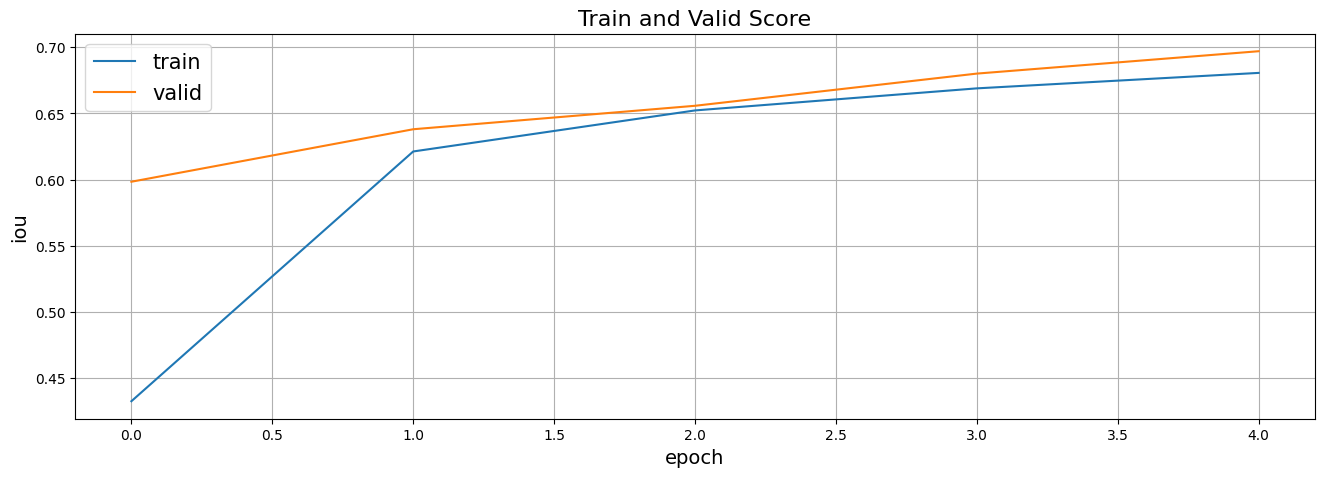

In [107]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_iou_history, label="train")
plt.plot(range(CFG.n_epochs), val_iou_history, label="valid")

plt.title("Train and Valid Score", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

Как можем заметить в данной задаче, модель с CNN показала себя лучше и обеспечила метрику IoU на 0.2 больше

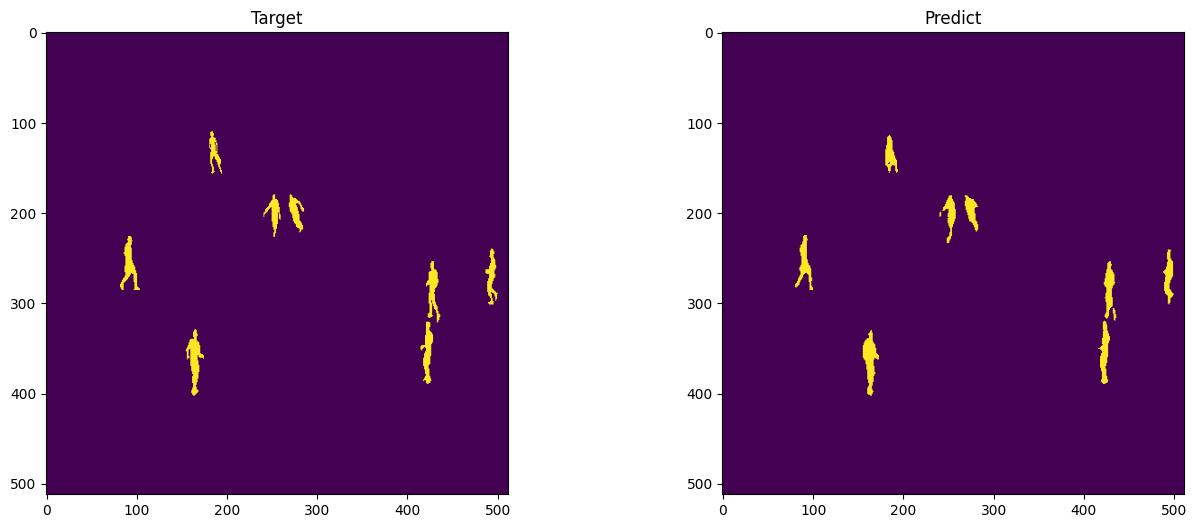

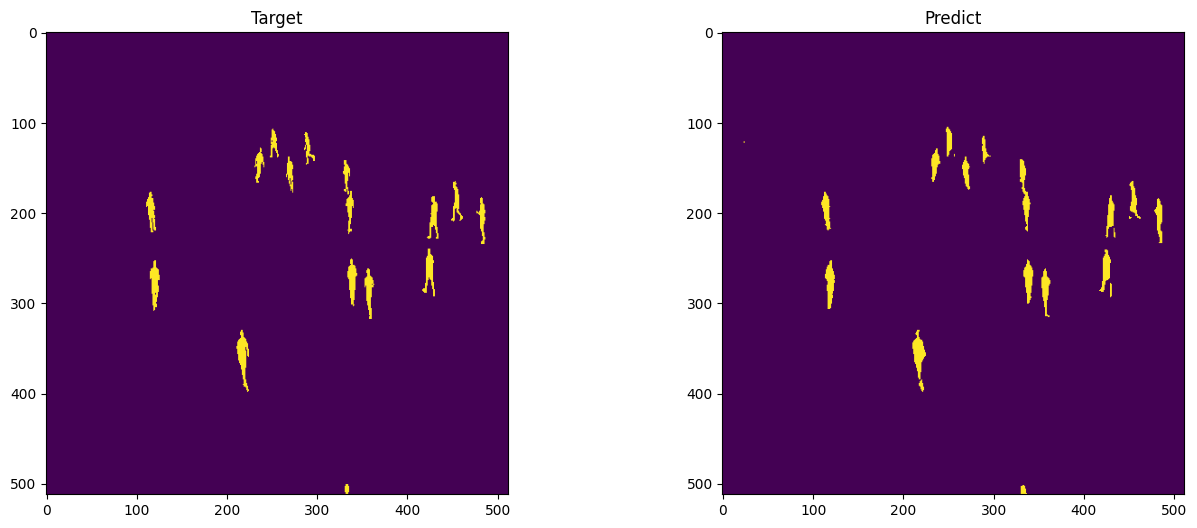

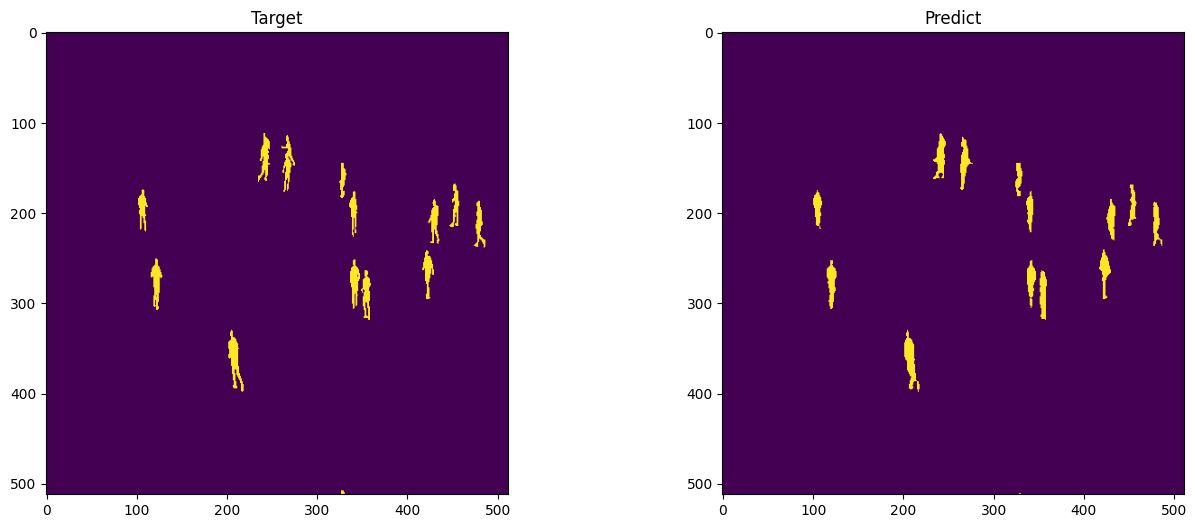

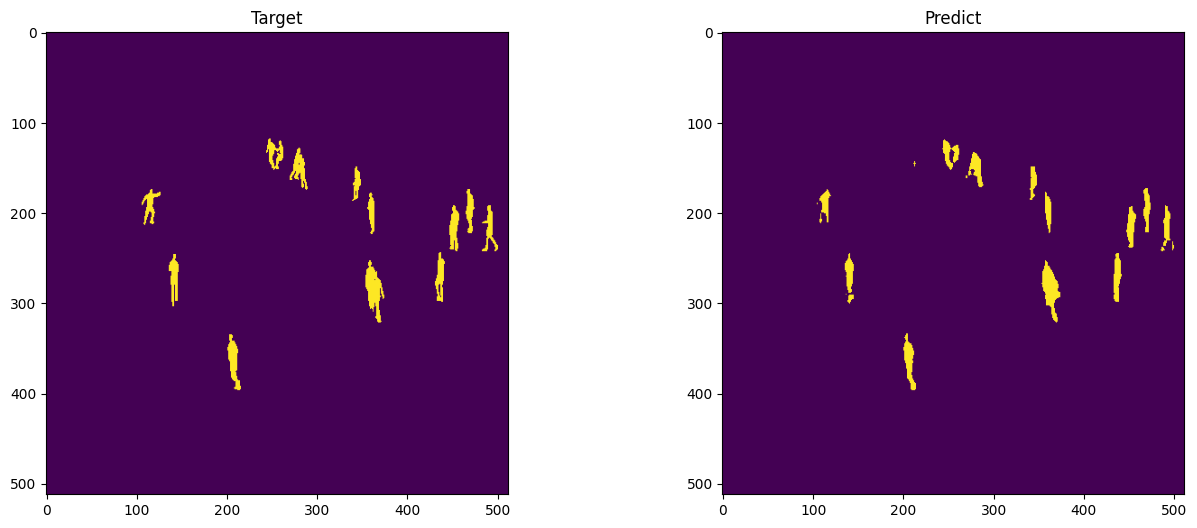

In [108]:
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        outputs = model(inputs)

        np_labels = labels.detach().cpu().numpy()
        np_outputs = outputs.detach().cpu().numpy()

        for i in range(len(np_labels)):
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(np_labels[i][0])
            plt.title("Target")
            plt.subplot(1, 2, 2)
            plt.imshow(np_outputs[i][0] >= 0)
            plt.title("Predict")
            plt.show()

        break

Уже по выводу результата можно заметить, что предсказанное значение меньше совпадает чем у CNN

Проведём серию экспериментов для выбора нового бейзлайна
1. Обычный бейзлайн
2. Увечим аугментацию с помощью изменения контрастности
3. Добавим рандомные приближения в датасет

In [111]:
import copy

def get_transforms_baseline():
    return A.Compose([
        A.HueSaturationValue(p=1.0, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
        A.HorizontalFlip(p=0.5),
    ], p=1.0)

def get_transforms_aug1():
    return A.Compose([
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.7),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
        A.HorizontalFlip(p=0.5),
    ], p=1.0)

def get_transforms_multiscale():
    return A.Compose([
        A.RandomResizedCrop(size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE), scale=(0.5, 1.0), ratio=(0.75, 1.33), p=1.0),
        A.HorizontalFlip(p=0.5),
    ], p=1.0)

def run_experiment(transform_fn, name):
    model_exp = copy.deepcopy(model).to(CFG.device)
    optimizer_exp = Adam(model_exp.parameters(), lr=CFG.lr)
    criterion = BCEWithLogitsLoss()

    ds_train = CustomDataset(train_indexes,
                             transform=transform_fn(),
                             preprocess=preprocess_input)
    ds_valid = CustomDataset(valid_indexes,
                             transform=transform_fn() if name=="aug1" else None,
                             preprocess=preprocess_input)
    dl_train = DataLoader(ds_train, batch_size=CFG.batch_size, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=CFG.batch_size, shuffle=False)

    best_iou = 0
    for epoch in range(3):
        # train
        model_exp.train()
        for batch in dl_train:
            imgs = batch["image"].to(CFG.device)
            msks = batch["mask"].to(CFG.device)
            optimizer_exp.zero_grad()
            preds = model_exp(imgs)
            loss = criterion(preds, msks)
            loss.backward()
            optimizer_exp.step()

        # val
        model_exp.eval()
        tot_iou = 0
        with torch.no_grad():
            for batch in dl_valid:
                imgs = batch["image"].to(CFG.device)
                msks = batch["mask"].to(CFG.device)
                preds = torch.sigmoid(model_exp(imgs)) >= 0.5
                tot_iou += iou(preds.cpu().numpy(), msks.cpu().numpy())
        avg_iou = tot_iou / len(dl_valid)
        best_iou = max(best_iou, avg_iou)

    return best_iou

exp_results = {}
exp_results["baseline"]      = run_experiment(get_transforms_baseline,      "baseline")
exp_results["augmented"]     = run_experiment(get_transforms_aug1,          "aug1")
exp_results["multiscale"]    = run_experiment(get_transforms_multiscale,     "multiscale")

print("Experiment IoU results:", exp_results)

Experiment IoU results: {'baseline': np.float64(0.7438873782713544), 'augmented': np.float64(0.6838918784360914), 'multiscale': np.float64(0.7002789892669607)}


По результатам базовый бейзлайн и с рандомным скалированием показала себя лучше всего

Будем использовать multiscale для разнообразия

Запустим процесс обучения для наших моделей Unet и SegFormer

In [112]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

In [113]:
preprocess_input = get_preprocessing_fn("resnet34", pretrained="imagenet")

Загрузим датасет используя обновленный бейзлайн

In [114]:
train_dataset = CustomDataset(
    train_indexes, transform=get_transforms_multiscale(), preprocess=preprocess_input
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_indexes, preprocess=preprocess_input)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)

In [115]:
model.to(CFG.device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=CFG.lr)

Запустим процесс обучения модели и посмотрим результаты

In [116]:
train_loss_history = []
val_loss_history = []
train_iou_history = []
val_iou_history = []

for epoch in range(CFG.n_epochs):
    train_loss = 0
    train_iou = 0
    model.train()
    for i, batch in tqdm(enumerate(train_dataloader)):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
        train_iou += _iou

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)

    val_loss = 0
    val_iou = 0
    model.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_dataloader)):
            inputs = batch["image"].to(CFG.device)
            labels = batch["mask"].to(CFG.device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
            val_iou += _iou

    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(
        "Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train IOU: {:.4f}, Val IOU: {:.4f}".format(
            epoch + 1, CFG.n_epochs, train_loss, val_loss, train_iou, val_iou
        )
    )

103it [00:28,  3.63it/s]
26it [00:02, 11.04it/s]


Epoch [1/5], Train Loss: 0.1056, Val Loss: 0.0262, Train IOU: 0.6250, Val IOU: 0.7144


103it [00:29,  3.45it/s]
26it [00:02,  9.62it/s]


Epoch [2/5], Train Loss: 0.0226, Val Loss: 0.0141, Train IOU: 0.7476, Val IOU: 0.8124


103it [00:29,  3.44it/s]
26it [00:02,  9.24it/s]


Epoch [3/5], Train Loss: 0.0173, Val Loss: 0.0160, Train IOU: 0.7640, Val IOU: 0.7710


103it [00:29,  3.44it/s]
26it [00:02, 10.68it/s]


Epoch [4/5], Train Loss: 0.0153, Val Loss: 0.3332, Train IOU: 0.7702, Val IOU: 0.1148


103it [00:29,  3.47it/s]
26it [00:02, 10.54it/s]

Epoch [5/5], Train Loss: 0.0161, Val Loss: 0.0096, Train IOU: 0.7581, Val IOU: 0.8356


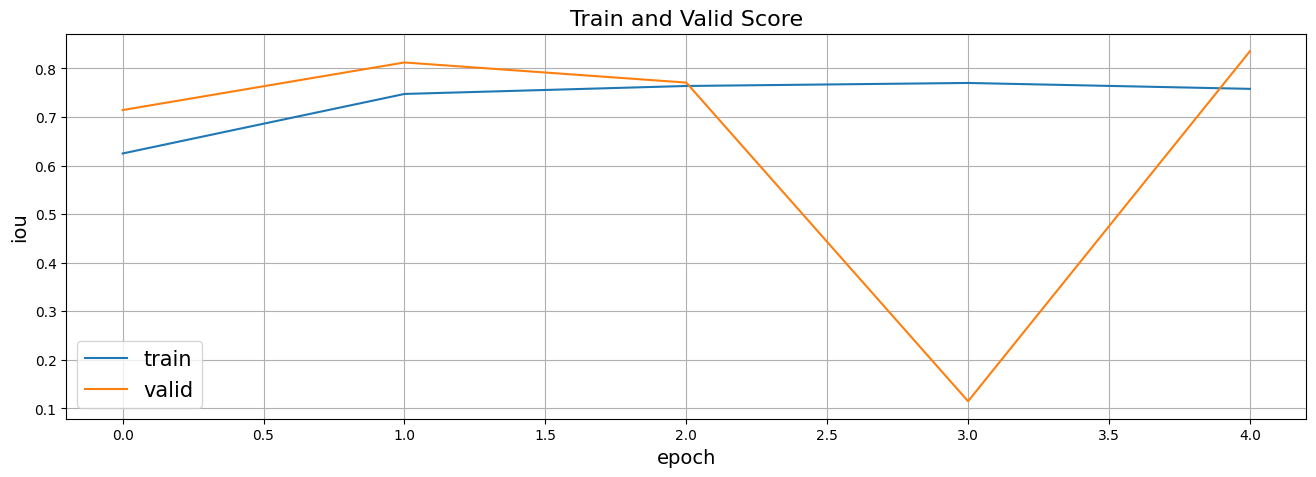

In [117]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_iou_history, label="train")
plt.plot(range(CFG.n_epochs), val_iou_history, label="valid")

plt.title("Train and Valid Score", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

Как можем заметить по результатам модель показала себя чуть хуже, чем базовый бейзлайн. Изучим как модель покажет себя с Трансформерной моделью

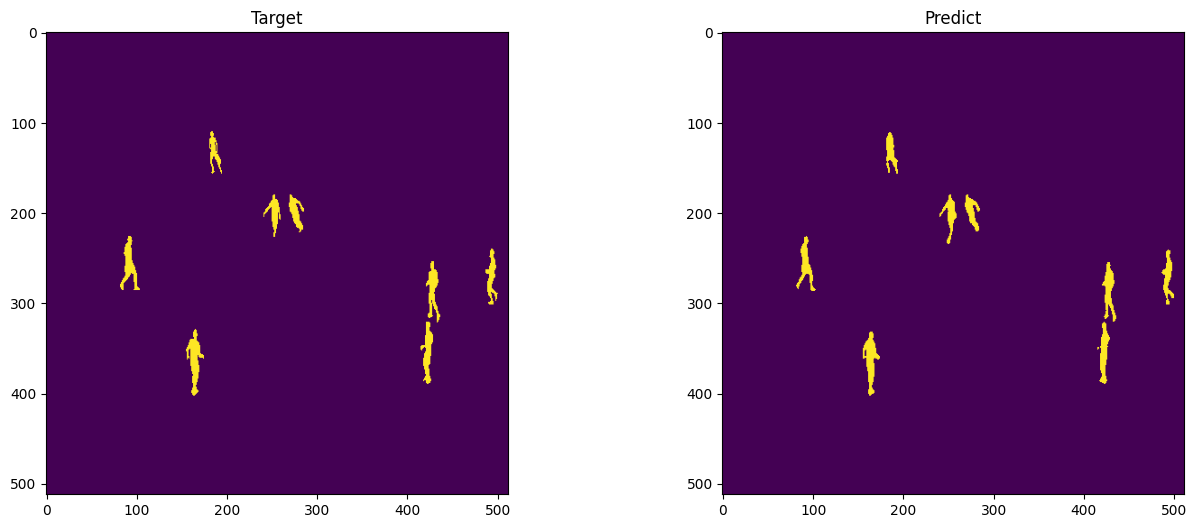

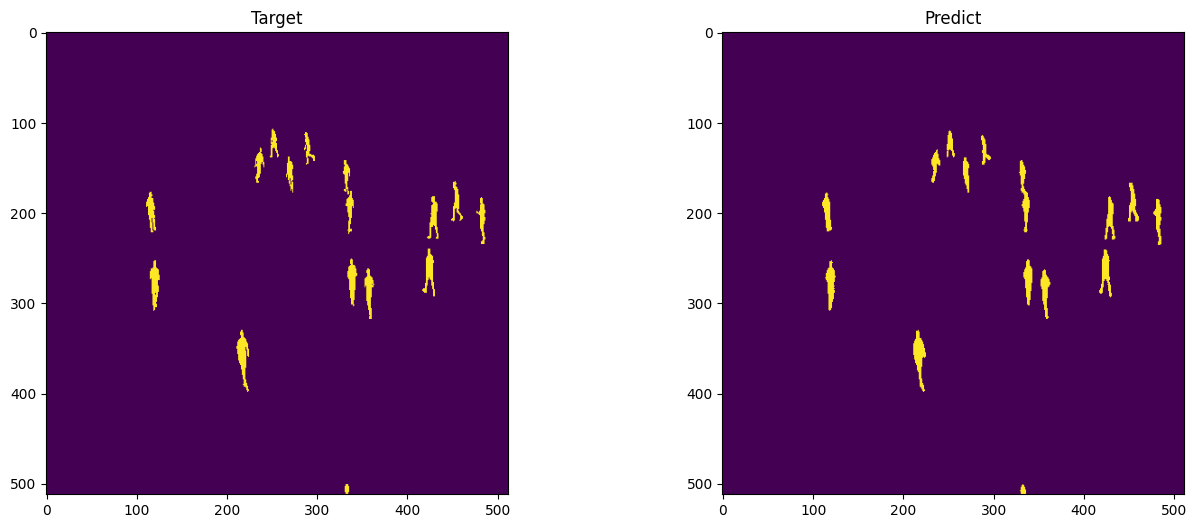

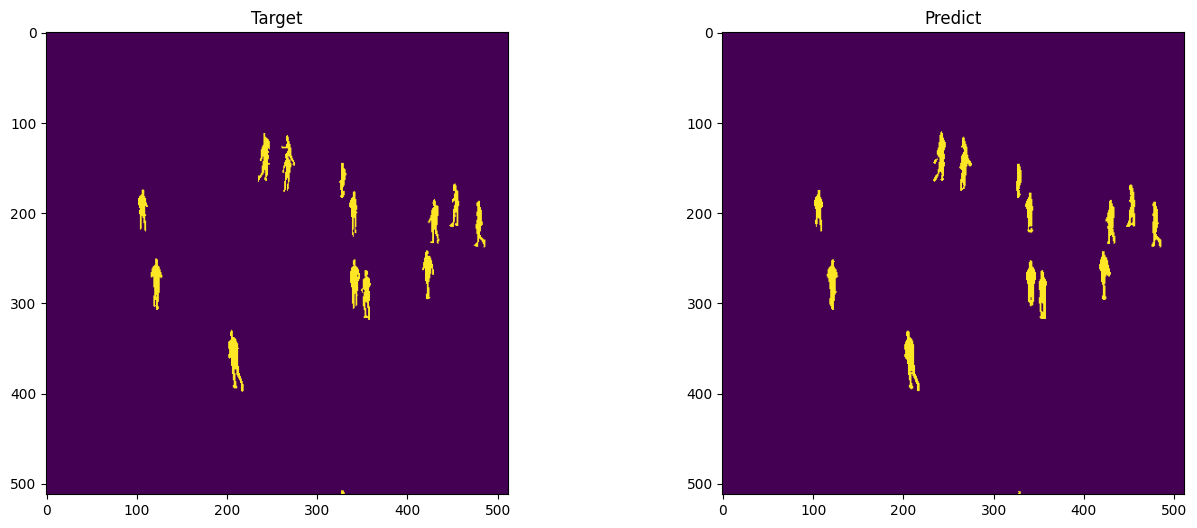

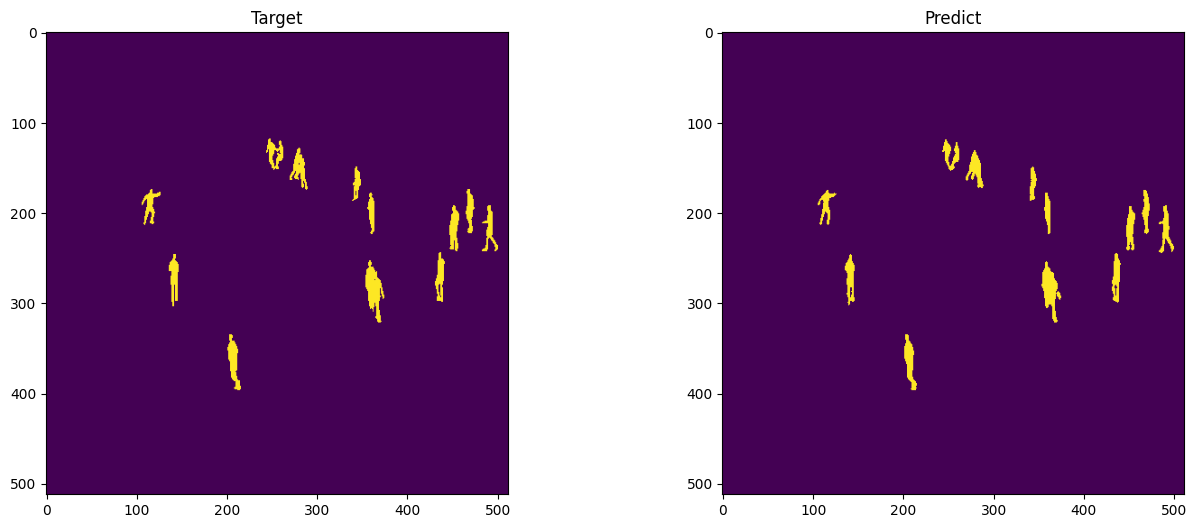

In [118]:
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        outputs = model(inputs)

        np_labels = labels.detach().cpu().numpy()
        np_outputs = outputs.detach().cpu().numpy()

        for i in range(len(np_labels)):
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(np_labels[i][0])
            plt.title("Target")
            plt.subplot(1, 2, 2)
            plt.imshow(np_outputs[i][0] >= 0)
            plt.title("Predict")
            plt.show()

        break

Визуализация результата показала себя не хуже базового бейзлайна для CNN модели

По аналогии запустим процесс для трансформерной модели

In [119]:
model = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

In [120]:
preprocess_input = get_preprocessing_fn("mit_b0", "imagenet")

In [123]:
train_dataset = CustomDataset(
    train_indexes, transform=get_transforms_multiscale(), preprocess=preprocess_input
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_indexes, preprocess=preprocess_input)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)

In [125]:
model.to(CFG.device)
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=CFG.lr)

In [126]:
train_loss_history, val_loss_history = [], []
train_iou_history,  val_iou_history  = [], []
for epoch in range(CFG.n_epochs):
    train_loss = 0
    train_iou = 0
    model.train()
    for i, batch in tqdm(enumerate(train_dataloader)):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
        train_iou += _iou

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)

    val_loss = 0
    val_iou = 0
    model.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_dataloader)):
            inputs = batch["image"].to(CFG.device)
            labels = batch["mask"].to(CFG.device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
            val_iou += _iou

    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(
        "Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train IOU: {:.4f}, Val IOU: {:.4f}".format(
            epoch + 1, CFG.n_epochs, train_loss, val_loss, train_iou, val_iou
        )
    )

103it [00:26,  3.92it/s]
26it [00:02, 10.81it/s]


Epoch [1/5], Train Loss: 0.1865, Val Loss: 0.0428, Train IOU: 0.3415, Val IOU: 0.6243


103it [00:25,  4.01it/s]
26it [00:02, 11.65it/s]


Epoch [2/5], Train Loss: 0.0318, Val Loss: 0.0339, Train IOU: 0.6240, Val IOU: 0.6479


103it [00:25,  4.05it/s]
26it [00:02, 11.44it/s]


Epoch [3/5], Train Loss: 0.0255, Val Loss: 0.0216, Train IOU: 0.6565, Val IOU: 0.6770


103it [00:25,  4.00it/s]
26it [00:02, 10.68it/s]


Epoch [4/5], Train Loss: 0.0219, Val Loss: 0.0172, Train IOU: 0.6754, Val IOU: 0.6888


103it [00:25,  4.02it/s]
26it [00:02, 11.67it/s]

Epoch [5/5], Train Loss: 0.0205, Val Loss: 0.0178, Train IOU: 0.6821, Val IOU: 0.6878


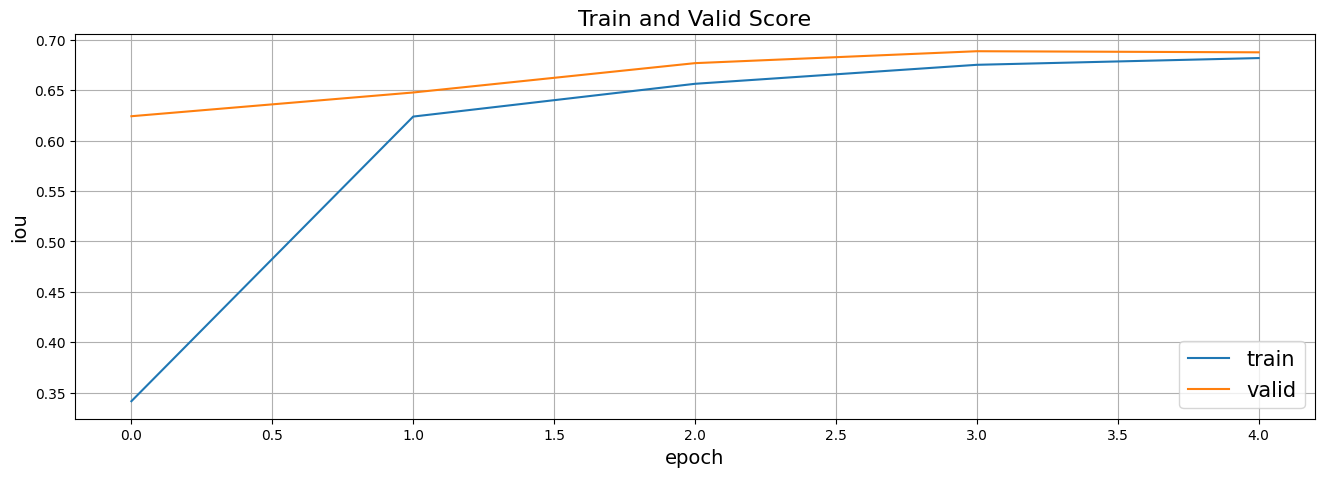

In [127]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_iou_history, label="train")
plt.plot(range(CFG.n_epochs), val_iou_history, label="valid")

plt.title("Train and Valid Score", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

Трансформерная модель не изменила своих результатов на новом бейзлайне и осталась на том же уровне

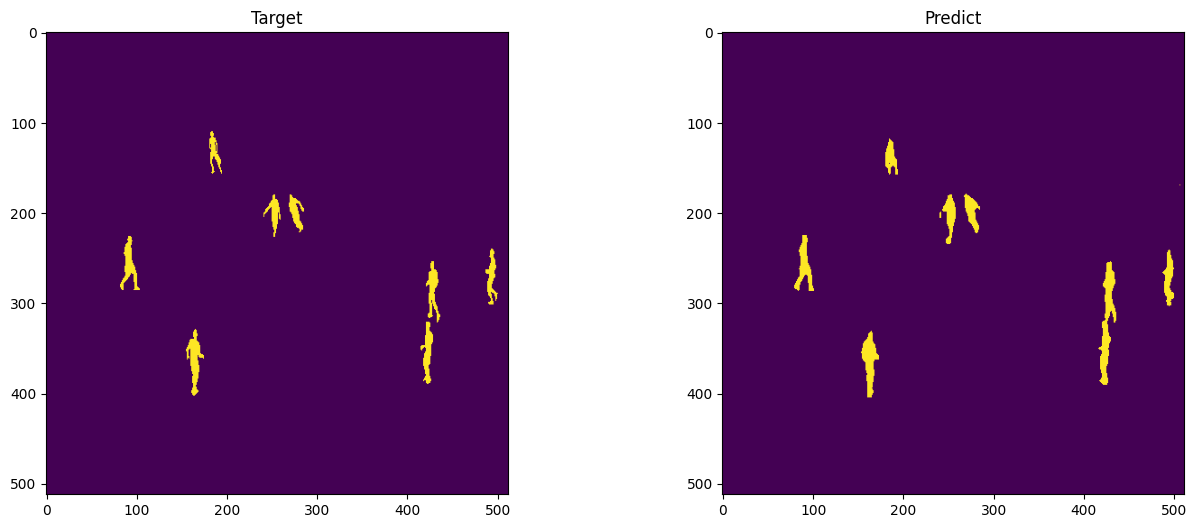

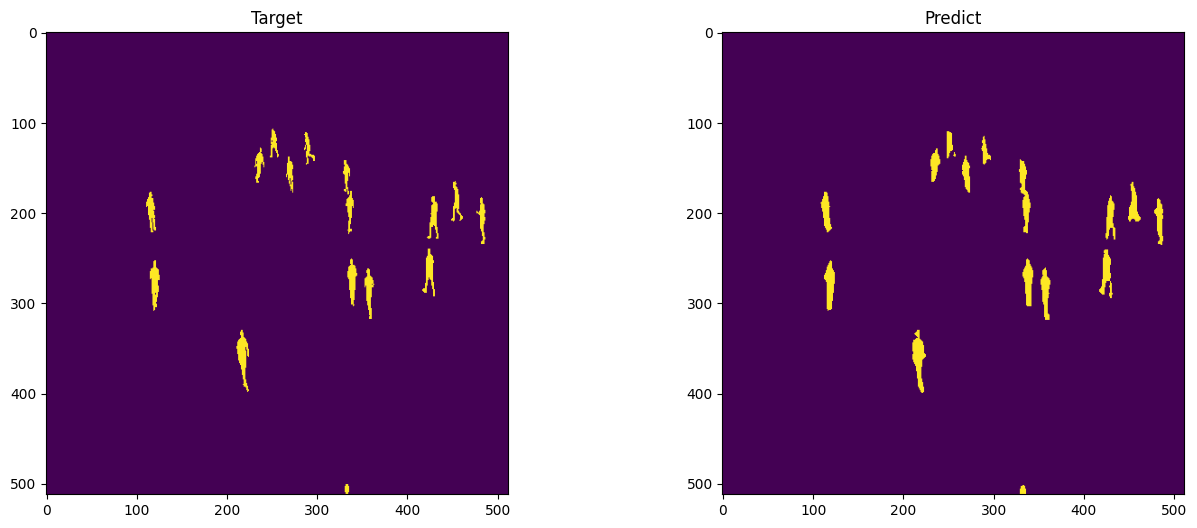

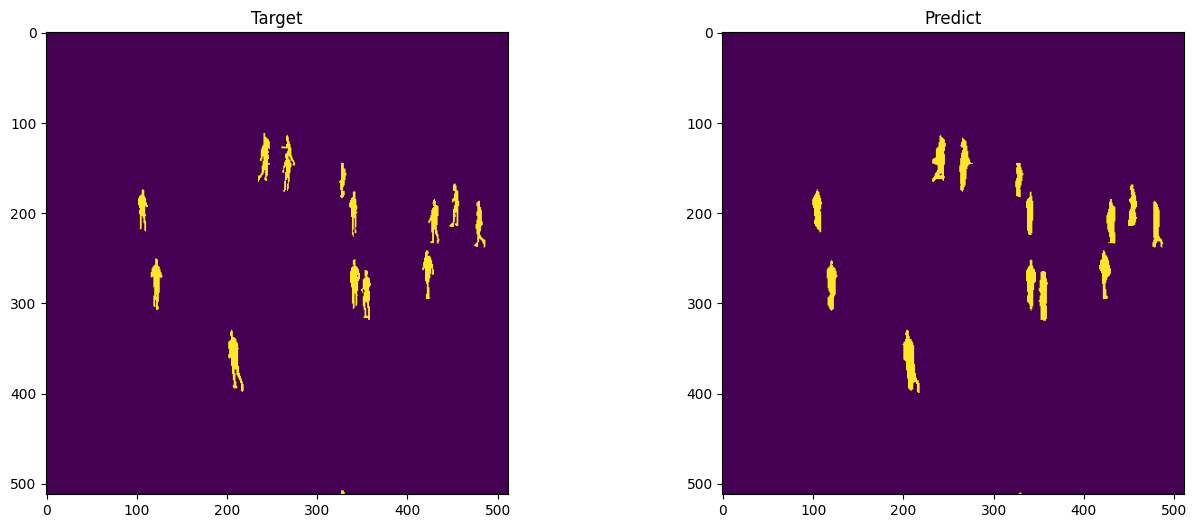

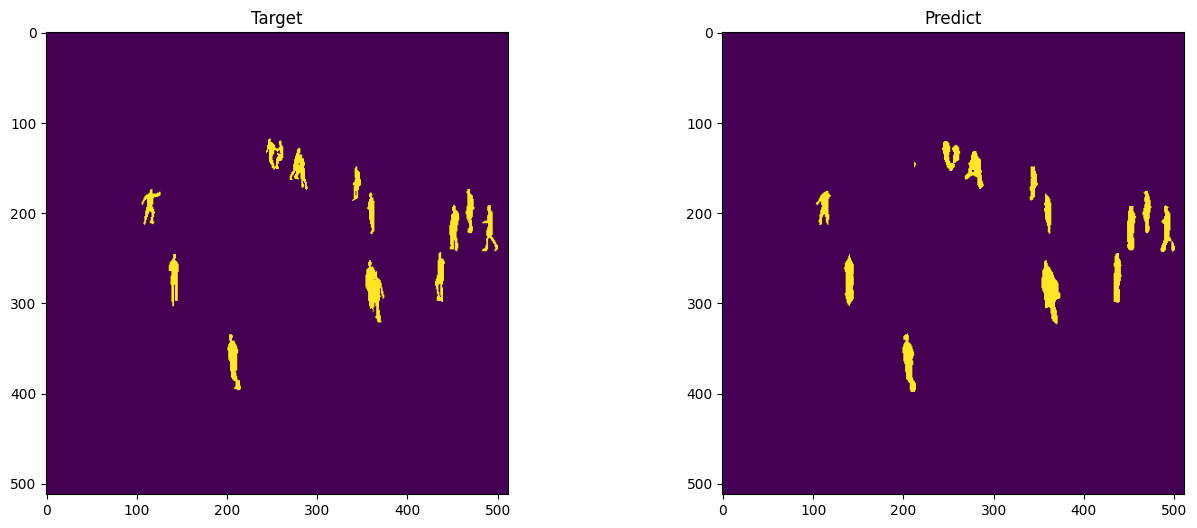

In [128]:
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        outputs = model(inputs)

        np_labels = labels.detach().cpu().numpy()
        np_outputs = outputs.detach().cpu().numpy()

        for i in range(len(np_labels)):
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(np_labels[i][0])
            plt.title("Target")
            plt.subplot(1, 2, 2)
            plt.imshow(np_outputs[i][0] >= 0)
            plt.title("Predict")
            plt.show()

        break

В визуализации модель все же показала себя хуже

Напишем собственную интерпретацию UNet подобной модели

In [131]:
import torch.nn as nn
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)

        u1 = self.up1(c3)
        d1 = self.dec1(torch.cat([u1, c2], dim=1))
        u2 = self.up2(d1)
        d2 = self.dec2(torch.cat([u2, c1], dim=1))
        return self.final(d2)

Напишем функцию для тренировки собственной модели и её оценки на тестовом датасете. Будем передавать функцию для запуска бейзлайна, как параметр

In [162]:
def train_and_evaluate(transform_fn):
    train_ds = CustomDataset(train_indexes, transform=transform_fn, preprocess=preprocess_input)
    valid_ds = CustomDataset(valid_indexes, preprocess=preprocess_input)
    train_dl = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=CFG.batch_size, shuffle=False)

    model = SimpleUNet().to(CFG.device)
    criterion = BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=CFG.lr)

    history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}

    for epoch in range(CFG.n_epochs):
        model.train()
        tloss, tiou = 0, 0
        for batch in tqdm(train_dl, desc=f'Train Epoch {epoch+1}'):
            imgs = batch["image"].to(CFG.device)
            msks = batch["mask"].to(CFG.device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, msks)
            loss.backward()
            optimizer.step()
            tloss += loss.item()
            preds_bin = (torch.sigmoid(preds) >= 0.5).cpu().numpy()
            msks_bin = msks.cpu().numpy().astype(bool)
            tiou += np.mean((preds_bin & msks_bin).sum((1,2,3)) /
                             ((preds_bin | msks_bin).sum((1,2,3)) + 1e-6))
        model.eval()
        vloss, viou = 0, 0
        with torch.no_grad():
            for batch in tqdm(valid_dl, desc=f'Valid Epoch {epoch+1}'):
                imgs = batch["image"].to(CFG.device)
                msks = batch["mask"].to(CFG.device)
                preds = model(imgs)
                loss = criterion(preds, msks)
                vloss += loss.item()
                preds_bin = (torch.sigmoid(preds) >= 0.5).cpu().numpy()
                msks_bin = msks.cpu().numpy().astype(bool)
                viou += np.mean((preds_bin & msks_bin).sum((1,2,3)) /
                             ((preds_bin | msks_bin).sum((1,2,3)) + 1e-6))
        history['train_loss'].append(tloss/len(train_dl))
        history['train_iou'].append(tiou/len(train_dl))
        history['val_loss'].append(vloss/len(valid_dl))
        history['val_iou'].append(viou/len(valid_dl))

    return history

In [163]:
baseline_hist = train_and_evaluate(get_transforms_baseline())
improved_hist = train_and_evaluate(get_transforms_multiscale())

Valid Epoch 5: 100%|██████████| 26/26 [00:07<00:00,  3.53it/s]


In [164]:
print("Baseline IoU:", baseline_hist['val_iou'][-1])
print("Improved IoU:", improved_hist['val_iou'][-1])

Baseline IoU: 0.8721550180841615
Improved IoU: 0.8535672247471157


Как можем заметить, наша модель показала себя на том же уровне, что и библиотечная модель UNet. Данная модель имеет место быть

Напишем собственную интерпретацию трансформерной модели. Используем трансформерный энкодер и эмбенндинги

In [169]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)
        b, c, h, w = x.shape
        x = x.flatten(2).transpose(1,2)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim=256, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_dim)
        self.attn  = nn.MultiheadAttention(emb_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_dim)
        hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp   = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, emb_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x_res = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = x_res + attn_out
        x_res = x
        x = self.norm2(x)
        x = x_res + self.mlp(x)
        return x

class TransformerSegmentationModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, patch_size=16, emb_dim=256, depth=6, num_heads=8):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_dim)
        num_patches = (TRAIN_IMAGE_SIZE // patch_size) ** 2
        self.pos_embed  = nn.Parameter(torch.zeros(1, num_patches, emb_dim))
        self.blocks     = nn.ModuleList([
            TransformerEncoderBlock(emb_dim, num_heads) for _ in range(depth)
        ])
        self.unpatch    = nn.ConvTranspose2d(emb_dim, num_classes, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x) + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        h = w = TRAIN_IMAGE_SIZE // self.patch_embed.patch_size
        x = x.transpose(1,2).reshape(B, -1, h, w)
        x = self.unpatch(x)
        return x

По аналогии с предыдущей моделью используем функцию для обучения и оценки трансформерной модели

In [172]:
def train_transformer(transform_fn):
    train_ds = CustomDataset(train_indexes, transform=transform_fn, preprocess=preprocess_input)
    valid_ds = CustomDataset(valid_indexes, preprocess=preprocess_input)
    dl_train = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
    dl_valid = DataLoader(valid_ds, batch_size=CFG.batch_size, shuffle=False)

    model = TransformerSegmentationModel().to(CFG.device)
    criterion = BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=CFG.lr)

    history = {'train_loss':[], 'train_iou':[], 'val_loss':[], 'val_iou':[]}

    for epoch in range(CFG.n_epochs):
        model.train()
        t_loss, t_iou = 0.0, 0.0
        for batch in tqdm(dl_train, desc=f'Transformer Train {epoch+1}'):
            imgs = batch["image"].to(CFG.device)
            msks = batch["mask"].to(CFG.device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss  = criterion(preds, msks)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            preds_bin = (torch.sigmoid(preds) >= 0.5).cpu().numpy()
            msks_bin  = msks.cpu().numpy().astype(bool)
            t_iou     += np.mean((preds_bin & msks_bin).sum((1,2,3)) /
                                 ((preds_bin | msks_bin).sum((1,2,3)) + 1e-6))
        t_loss /= len(dl_train)
        t_iou  /= len(dl_train)

        model.eval()
        v_loss, v_iou = 0.0, 0.0
        with torch.no_grad():
            for batch in tqdm(dl_valid, desc=f'Transformer Valid {epoch+1}'):
                imgs = batch["image"].to(CFG.device)
                msks = batch["mask"].to(CFG.device)
                preds = model(imgs)
                loss  = criterion(preds, msks)
                v_loss += loss.item()
                preds_bin = (torch.sigmoid(preds) >= 0.5).cpu().numpy()
                msks_bin  = msks.cpu().numpy().astype(bool)
                v_iou     += np.mean((preds_bin & msks_bin).sum((1,2,3)) /
                                     ((preds_bin | msks_bin).sum((1,2,3)) + 1e-6))
        v_loss /= len(dl_valid)
        v_iou  /= len(dl_valid)

        history['train_loss'].append(t_loss)
        history['train_iou'].append(t_iou)
        history['val_loss'].append(v_loss)
        history['val_iou'].append(v_iou)

        print(f"Epoch {epoch+1}/{CFG.n_epochs} | Train IoU: {t_iou:.4f} | Val IoU: {v_iou:.4f}")

    return history

In [173]:
baseline_hist = train_transformer(get_transforms_baseline())
improved_hist = train_transformer(get_transforms_multiscale())

Transformer Valid 1: 100%|██████████| 26/26 [00:02<00:00, 12.78it/s]


Epoch 1/5 | Train IoU: 0.1625 | Val IoU: 0.5092


Transformer Valid 2: 100%|██████████| 26/26 [00:02<00:00, 12.86it/s]


Epoch 2/5 | Train IoU: 0.4844 | Val IoU: 0.5899


Transformer Valid 3: 100%|██████████| 26/26 [00:02<00:00, 12.63it/s]


Epoch 3/5 | Train IoU: 0.5622 | Val IoU: 0.6259


Transformer Valid 4: 100%|██████████| 26/26 [00:02<00:00, 11.02it/s]


Epoch 4/5 | Train IoU: 0.6271 | Val IoU: 0.6830


Transformer Valid 5: 100%|██████████| 26/26 [00:02<00:00, 12.71it/s]


Epoch 5/5 | Train IoU: 0.6582 | Val IoU: 0.6996


Transformer Valid 1: 100%|██████████| 26/26 [00:02<00:00, 12.77it/s]


Epoch 1/5 | Train IoU: 0.2511 | Val IoU: 0.3457


Transformer Valid 2: 100%|██████████| 26/26 [00:02<00:00, 12.69it/s]


Epoch 2/5 | Train IoU: 0.5263 | Val IoU: 0.4921


Transformer Valid 3: 100%|██████████| 26/26 [00:02<00:00, 11.95it/s]


Epoch 3/5 | Train IoU: 0.5871 | Val IoU: 0.6311


Transformer Valid 4: 100%|██████████| 26/26 [00:02<00:00, 12.72it/s]


Epoch 4/5 | Train IoU: 0.6225 | Val IoU: 0.6582


Transformer Valid 5: 100%|██████████| 26/26 [00:02<00:00, 12.80it/s]

Epoch 5/5 | Train IoU: 0.6499 | Val IoU: 0.6857


In [174]:
print("Baseline IoU:", baseline_hist['val_iou'][-1])
print("Improved IoU:", improved_hist['val_iou'][-1])

Baseline IoU: 0.6996357612559987
Improved IoU: 0.6857353015201858


Полученный результат модели опять таки показал себя хуже, чем у CNN. Возможно это связанно с тем, что трансформерная модель все же требует большего времени обучения.

# Итоговые результаты

| Модель            | IoU    |
|-------------------|--------|
| CNN-LIB           | 0.8275 |
| SEGFORMER-LIB     | 0.6971 |
| CNN-LIB-IMP       | 0.8356 |
| SEGFORMER-LIB-IMP | 0.6878 |
| CNN               | 0.8721 |
| SEGFORMER         | 0.6996 |
| CNN-IMP           | 0.8535 |
| SEGFORMER-IMP     | 0.6857 |

# Заключение

При решении данной задачи лучше всего показал себя CNN модель. При загрузке трансформерной модели можно было увидеть, что она имеет большее количество весов. Возможно необходимо увеличить время обучения и количество эпох. Улучшение бейзлайна не сильно помогло улучшить метрику. Скорее всего это связано с форматом датасета и доменной областью. Чаще всего снимки поля представлены в одинаковом формате и не обладают сильными отличиями.

Собстевенная реализация CNN (UNet подобной модели) показала себя даже лучше библиотечной.